## Fine-tune TrOCR on a Custom Dataset

This notebook demonstrates how to fine-tune the HuggingFace version of TrOCR using a custom dataset of handwritten text images and transcriptions. It includes optional support for freezing encoder or decoder layers during training.

## Set-up environment
First, let's install all required libraries:

In [ ]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q jiwer
!pip install -q datasets
!pip install -q evaluate
!pip install -q -U accelerate

!pip install -q matplotlib
!pip install -q protobuf==3.20.1
!pip install -q tensorboard

##  Upload and extract your dataset (image folder) in Colab

In [ ]:
!unzip "/content/cropped.zip"

## Imports

In [ ]:
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)

c:\Users\ASHUTOSH\.conda\envs\test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
bold = f"\033[1m"
reset = f"\033[0m"

In [ ]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
df=pd.read_csv(r"/content/final_data.csv")

In [ ]:
df=df[(df["total"]>=30) & (df["total"]<=50)]

### Shuffle and splitting the data in train,test and validation set

In [ ]:
shuffled_df = df.sample(frac=1).reset_index(drop=True)
shuffled_df=shuffled_df.iloc[:,:5]
shuffled_df.sample(4)

,imscanno,individual_total,total,flg,barcode
6501,217223,41,41,True,727996.0
8350,214704,36,36,True,978480.0
9135,212468,50,50,True,830705.0
2255,413124,42,42,True,1039113.0


In [ ]:
shuffled_df.shape

(10500, 6)

In [ ]:
train_df=shuffled_df[:part1]
test_df=shuffled_df[part1:part2]
valid_df=shuffled_df[part2:]
train_df.shape,test_df.shape,valid_df.shape

((7349, 6), (1576, 6), (1575, 6))

## Training and Dataset Configurations

In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 10
    EPOCHS:        int = 10
    LEARNING_RATE: float = 0.00005

@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = 'conten/croppe/cropped//'

@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-handwritten'

In [ ]:
train_df.head()

,imscanno,individual_total,total,flg,barcode,words
0,219200,47,47,True,721843.0,Forty Seven
1,405154,33,33,True,956726.0,Thirty Three
2,411881,33,33,True,995771.0,Thirty Three
3,227063,35,35,True,702784.0,Thirty Five
4,217091,34,34,True,696003.0,Thirty Four


In [ ]:
test_df.head()

,imscanno,individual_total,total,flg,barcode,words
7349,412659,36,36,True,719484.0,Thirty Six
7350,227329,34,34,True,783333.0,Thirty Four
7351,220573,35,35,True,974182.0,Thirty Five
7352,228614,41,41,True,844496.0,Forty One
7353,220715,41,41,True,822575.0,Forty One


In [ ]:
# Augmentations.
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])

In [ ]:
class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # The image file name.
        file_name = self.df['imscanno'].iloc[idx]
        text = self.df['words'].iloc[idx]
       # Read the image, apply augmentations, and get the transformed pixels.
        image = Image.open(self.root_dir+ str(file_name) + "_cropped_0.jpg").convert('RGB')
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        # Pass the text through the tokenizer and get the labels,
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        # We are using -100 as the padding token.
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        # print(encoding)
        return encoding

In [ ]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
train_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT),
    df=train_df,
    processor=processor
)
valid_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT),
    df=test_df,
    processor=processor
)

c:\Users\ASHUTOSH\.conda\envs\test\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 7349
Number of validation examples: 1576


In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


 ## Dataset Preview

(np.float64(-0.5), np.float64(414.5), np.float64(112.5), np.float64(-0.5))

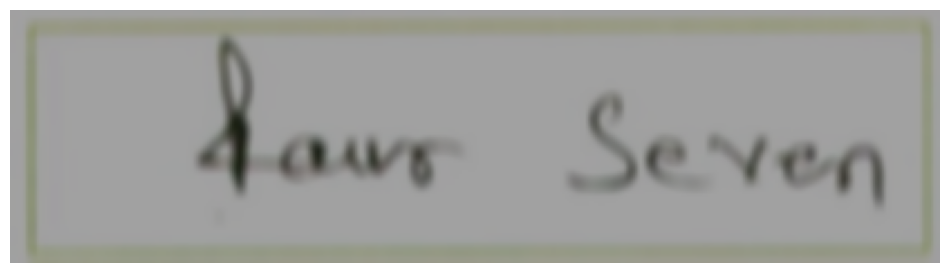

In [ ]:
image = Image.open(train_dataset.root_dir + str(train_df['imscanno'][0]) + "_cropped_0.jpg").convert("RGB")
image = train_transforms(image)
plt.imshow(image)
plt.axis('off')

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Forty Seven


## TrOCR Architecture Summary
1. Encoder: A Vision Transformer (ViT) processes the image and converts it into visual embeddings.

2. Decoder: A language model (like GPT-2 or BART-style Transformer) generates text token by token from the encoder output.

## Initialize the Model

## Strategy 1: Train All Parameters (Encoder + Decoder)
#### When to Use:
1. Your dataset is very different from the original (e.g., new language, handwriting, new domain).

2. You want maximum model flexibility.

3. You have enough compute resources.

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: [

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

## Strategy 2: Freeze Encoder, Train Only Decoder
#### When to Use:
1. You’re dealing with similar image types (e.g., printed English text) but different output formats.Example: Converting scanned English forms to structured JSON.

2. You want the model to learn new language tasks.

In [ ]:
# # Load the pretrained model
# model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
# # model.to(device)

# # Freeze the encoder parameters to train only the decoder
# for param in model.encoder.parameters():
#     param.requires_grad = False

# # Print the model to verify which parameters are frozen
# print(model)

# # Calculate and display total parameters and trainable parameters
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")

# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters (decoder only).")

## Strategy 3: Freeze Decoder, Train Only Encoder
#### When to Use:
1. You’re using new types of images (e.g., handwritten text, new fonts), but the language remains similar.Example: Printed-to-handwritten transfer within the same language.

2. You want to preserve language modeling quality.

In [ ]:
# # Load the pretrained model
# model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
# # model.to(device)  # Uncomment and move the model to GPU or CPU as needed

# # Freeze decoder parameters (i.e., do NOT train decoder)
# for param in model.decoder.parameters():
#     param.requires_grad = False

# # (Optional) Freeze the language model head (if you don't want to fine-tune it either)
# if hasattr(model, 'lm_head'):
#     for param in model.lm_head.parameters():
#         param.requires_grad = False

# # (Optional) Freeze cross-attention layers in decoder if necessary
# if hasattr(model.decoder, "encoder_attn"):
#     for param in model.decoder.encoder_attn.parameters():
#         param.requires_grad = False

# # Print model structure (to verify frozen parts)
# print(model)

# # Count total parameters
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")

# # Count only trainable parameters (encoder part)
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters (encoder only).")

## Strategy 4: Train Only Last N Layers of Both
When to Use:
1. You want to fine-tune efficiently with fewer trainable parameters.

2. You’re adapting the model slightly (e.g., slight font/layout change or domain shift).

3. You want to reduce overfitting or train on limited hardware.

In [ ]:
# # Load pretrained TrOCR model
# model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)

# # Freeze all parameters
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze last N layers of encoder
# N = 4  # Number of last layers to train

# # Check and unfreeze encoder layers
# if hasattr(model.encoder, "encoder") and hasattr(model.encoder.encoder, "layer"):
#     encoder_layers = model.encoder.encoder.layer
#     for layer in encoder_layers[-N:]:
#         for param in layer.parameters():
#             param.requires_grad = True
# else:
#     print("Warning: Could not find encoder layers. Check encoder structure.")

# # Unfreeze last N layers of decoder
# if hasattr(model.decoder, "model") and hasattr(model.decoder.model, "decoder"):
#     decoder_layers = model.decoder.model.decoder.layers
#     for layer in decoder_layers[-N:]:
#         for param in layer.parameters():
#             param.requires_grad = True
# else:
#     print("Warning: Could not find decoder layers. Check decoder structure.")

# # Print parameter summary
# total_params = sum(p.numel() for p in model.parameters())
# trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"Total Parameters: {total_params:,}")
# print(f"Trainable Parameters (last {N} layers only): {trainable_params:,}")


## Model Configurations

In [ ]:
# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id

# model.config.max_length = 20
# model.config.early_stopping = True
# model.config.no_repeat_ngram_size = 3
# model.config.length_penalty = 2.0
# model.config.num_beams = 4

We use the AdamW optimizer here with a weight decay of 0.0005.

In [ ]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

## Evaluation Metric

In [ ]:
cer_metric = evaluate.load('cer')

In [ ]:
def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

## Training and Validation Loops

In [ ]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    fp16=True,
    output_dir='seq2seq_model_printed/',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=5,
    report_to='tensorboard',
    num_train_epochs=TrainingConfig.EPOCHS
)

c:\Users\ASHUTOSH\.conda\envs\test\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Initialize trainer.
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_cer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator
)

c:\Users\ASHUTOSH\.conda\envs\test\lib\site-packages\transformers\models\trocr\processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


## Train

In [ ]:
res = trainer.train()

 10%|█         | 735/7350 [1:22:46<11:40:59,  6.36s/it]

{'loss': 0.9029, 'grad_norm': 9.791276931762695, 'learning_rate': 4.5e-05, 'epoch': 1.0}


c:\Users\ASHUTOSH\.conda\envs\test\lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
                                                       
 10%|█         | 735/7350 [1:33:41<11:40:59,  6.36s/it]

{'eval_loss': 0.4477401077747345, 'eval_cer': 0.2651417525773196, 'eval_runtime': 655.0985, 'eval_samples_per_second': 2.406, 'eval_steps_per_second': 0.241, 'epoch': 1.0}


 20%|██        | 1470/7350 [2:55:09<10:25:27,  6.38s/it] 

{'loss': 0.2113, 'grad_norm': 5.290979385375977, 'learning_rate': 4e-05, 'epoch': 2.0}


c:\Users\ASHUTOSH\.conda\envs\test\lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
                                                        
 20%|██        | 1470/7350 [3:05:54<10:25:27,  6.38s/it]

{'eval_loss': 0.12932780385017395, 'eval_cer': 0.06217783505154639, 'eval_runtime': 645.4029, 'eval_samples_per_second': 2.442, 'eval_steps_per_second': 0.245, 'epoch': 2.0}


 30%|███       | 2205/7350 [4:29:32<9:48:03,  6.86s/it]   

{'loss': 0.1095, 'grad_norm': 9.521843910217285, 'learning_rate': 3.5e-05, 'epoch': 3.0}


c:\Users\ASHUTOSH\.conda\envs\test\lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
                                                       
 30%|███       | 2205/7350 [4:40:31<9:48:03,  6.86s/it]

{'eval_loss': 0.09642406553030014, 'eval_cer': 0.06907216494845361, 'eval_runtime': 658.6058, 'eval_samples_per_second': 2.393, 'eval_steps_per_second': 0.24, 'epoch': 3.0}


 40%|████      | 2940/7350 [6:05:50<8:08:42,  6.65s/it]   

{'loss': 0.0737, 'grad_norm': 0.01341269537806511, 'learning_rate': 3e-05, 'epoch': 4.0}


c:\Users\ASHUTOSH\.conda\envs\test\lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
                                                       
 40%|████      | 2940/7350 [6:16:42<8:08:42,  6.65s/it]

{'eval_loss': 0.06433337926864624, 'eval_cer': 0.03240979381443299, 'eval_runtime': 652.1, 'eval_samples_per_second': 2.417, 'eval_steps_per_second': 0.242, 'epoch': 4.0}


 50%|█████     | 3675/7350 [7:42:11<6:52:50,  6.74s/it]   

{'loss': 0.054, 'grad_norm': 0.19493266940116882, 'learning_rate': 2.5e-05, 'epoch': 5.0}


c:\Users\ASHUTOSH\.conda\envs\test\lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
                                                       
 50%|█████     | 3675/7350 [7:53:06<6:52:50,  6.74s/it]

{'eval_loss': 0.05764089152216911, 'eval_cer': 0.030670103092783504, 'eval_runtime': 655.6217, 'eval_samples_per_second': 2.404, 'eval_steps_per_second': 0.241, 'epoch': 5.0}


 60%|██████    | 4410/7350 [9:19:01<5:31:12,  6.76s/it]   

{'loss': 0.0343, 'grad_norm': 0.5212064981460571, 'learning_rate': 2e-05, 'epoch': 6.0}


c:\Users\ASHUTOSH\.conda\envs\test\lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
                                                       
 60%|██████    | 4410/7350 [9:30:02<5:31:12,  6.76s/it]

{'eval_loss': 0.06900147348642349, 'eval_cer': 0.04394329896907216, 'eval_runtime': 661.0965, 'eval_samples_per_second': 2.384, 'eval_steps_per_second': 0.239, 'epoch': 6.0}


 70%|███████   | 5145/7350 [10:57:11<4:08:38,  6.77s/it]  

{'loss': 0.0248, 'grad_norm': 0.005898377392441034, 'learning_rate': 1.5e-05, 'epoch': 7.0}


c:\Users\ASHUTOSH\.conda\envs\test\lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
                                                        
 70%|███████   | 5145/7350 [11:08:12<4:08:38,  6.77s/it]

{'eval_loss': 0.042948175221681595, 'eval_cer': 0.023195876288659795, 'eval_runtime': 660.9019, 'eval_samples_per_second': 2.385, 'eval_steps_per_second': 0.239, 'epoch': 7.0}


 80%|████████  | 5880/7350 [12:34:04<2:45:07,  6.74s/it]   

{'loss': 0.0201, 'grad_norm': 0.0003950319660361856, 'learning_rate': 1e-05, 'epoch': 8.0}


c:\Users\ASHUTOSH\.conda\envs\test\lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
                                                        
 80%|████████  | 5880/7350 [12:45:06<2:45:07,  6.74s/it]

{'eval_loss': 0.04646909609436989, 'eval_cer': 0.04220360824742268, 'eval_runtime': 662.0506, 'eval_samples_per_second': 2.38, 'eval_steps_per_second': 0.239, 'epoch': 8.0}


 90%|█████████ | 6615/7350 [14:10:23<1:21:50,  6.68s/it]  

{'loss': 0.0095, 'grad_norm': 0.013037205673754215, 'learning_rate': 5e-06, 'epoch': 9.0}


c:\Users\ASHUTOSH\.conda\envs\test\lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
                                                        
 90%|█████████ | 6615/7350 [14:21:21<1:21:50,  6.68s/it]

{'eval_loss': 0.05621664226055145, 'eval_cer': 0.03324742268041237, 'eval_runtime': 657.7152, 'eval_samples_per_second': 2.396, 'eval_steps_per_second': 0.24, 'epoch': 9.0}


100%|██████████| 7350/7350 [15:46:42<00:00,  6.71s/it]    

{'loss': 0.0075, 'grad_norm': 23.419857025146484, 'learning_rate': 0.0, 'epoch': 10.0}


c:\Users\ASHUTOSH\.conda\envs\test\lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
                                                      
100%|██████████| 7350/7350 [15:57:38<00:00,  6.71s/it]

{'eval_loss': 0.04089360684156418, 'eval_cer': 0.02860824742268041, 'eval_runtime': 656.1833, 'eval_samples_per_second': 2.402, 'eval_steps_per_second': 0.241, 'epoch': 10.0}


100%|██████████| 7350/7350 [15:57:40<00:00,  7.82s/it]


{'train_runtime': 57460.2933, 'train_samples_per_second': 1.279, 'train_steps_per_second': 0.128, 'train_loss': 0.14476655720042533, 'epoch': 10.0}


In [ ]:
res

TrainOutput(global_step=7350, training_loss=0.14476655720042533, metrics={'train_runtime': 57460.2933, 'train_samples_per_second': 1.279, 'train_steps_per_second': 0.128, 'total_flos': 8.791218278451118e+18, 'train_loss': 0.14476655720042533, 'epoch': 10.0})

In [ ]:
res.global_step

7350

## Inference

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [ ]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
# trained_model = VisionEncoderDecoderModel.from_pretrained('seq2seq_model_printed/checkpoint-'+str(res.global_step)).to(device)
trained_model = VisionEncoderDecoderModel.from_pretrained('seq2seq_model_printed/checkpoint-'+str(res.global_step))

In [ ]:
trained_model

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

## Saving Model checkpoint

In [ ]:
# prompt: give code to zip folder

import zipfile

def zip_folder(folder_path, zip_path):
  """Zips a folder.

  Args:
      folder_path: Path to the folder to zip.
      zip_path: Path to the output zip file.
  """
  with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(folder_path):
      for file in files:
        zipf.write(os.path.join(root, file),
                   os.path.relpath(os.path.join(root, file),
                                   os.path.join(folder_path, '..')))

# Example usage:
zip_folder('/content/seq2seq_model_printed/checkpoint-15625', '/content/checkpoint-15625.zip')
